In [2]:
%pip install git+https://github.com/gbdrt/mu-ppl

  Cloning https://github.com/gbdrt/mu-ppl to /tmp/pip-req-build-2hwf1jk0
  Running command git clone --filter=blob:none --quiet https://github.com/gbdrt/mu-ppl /tmp/pip-req-build-2hwf1jk0
  Resolved https://github.com/gbdrt/mu-ppl to commit 69f58a3ba7b1fb3071f696b6d95218394cb0a0ce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
from mu_ppl import *

# [LICS 2025 - Tutorial on Linear Logic and Probabilistic Programming](https://lics.siglog.org/lics25/)


Probabilistic programs represent random variables.

In [4]:
def dice() -> int:
    a = sample(RandInt(1, 6), name="a")
    b = sample(RandInt(1, 6), name="b")
    return a + b

We can run the experiment representing the random variable.

In [5]:
dice()

2

The law of the random variable can be computed by an inference algorithm. 

For instance the enumeration algorithm for discrete distributions.

In [6]:
with Enumeration():
    dist: Categorical[int] = infer(dice)

We can get a sample of the distribution.


In [7]:
sample(dist)

4

We can compute the statistics of the distribution  and vizualize its mass function.

mean:  7.0 
standard deviation:  2.4494897427831783


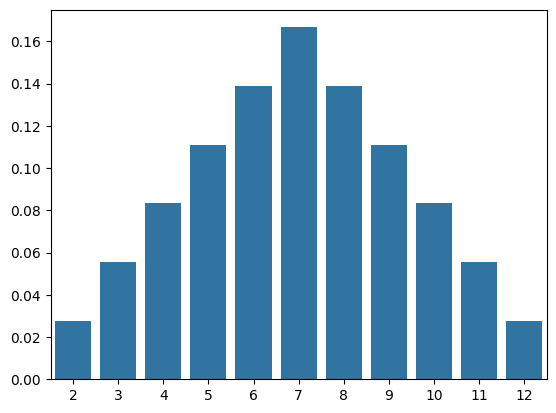

In [8]:

s = dist.stats()
print("mean: ",s[0], "\nstandard deviation: ", s[1])
viz(dist)


Questions on a Bayesian Networks can be modeled.

100%|██████████| 100/100 [00:00<00:00, 179167.19it/s]

(0.8679245283018868, 0.3418128057789596)


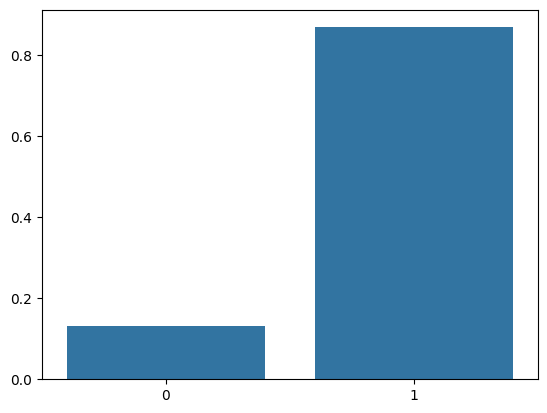

In [ ]:
from mu_ppl import *
import matplotlib.pyplot as plt

def wet() -> bool:
    cloudy = sample(Bernoulli(0.5), name="cloudy")
    
    p_sprinkle, p_rain = (0.1, 0.8) if cloudy else (0.5, 0.2)
    sprinkle = sample(Bernoulli(p_sprinkle), name="sprinkle")
    rain = sample(Bernoulli(p_rain), name="rain")
        
    p_wet = 0.99 if (sprinkle and rain) else 0.9 if (sprinkle != rain) else 0
    wet = sample(Bernoulli(p_wet), name="wet")
    assume(rain)
    return wet

with Enumeration():
    dist: Categorical[bool] = infer(wet)  
    print(dist.stats())
    viz(dist)
    plt.show()

Some programs need streams of i.i.d. copies of a random variable.

100%|██████████| 10000/10000 [00:00<00:00, 477983.36it/s]

(3.314800000000001, 2.789422708716769)


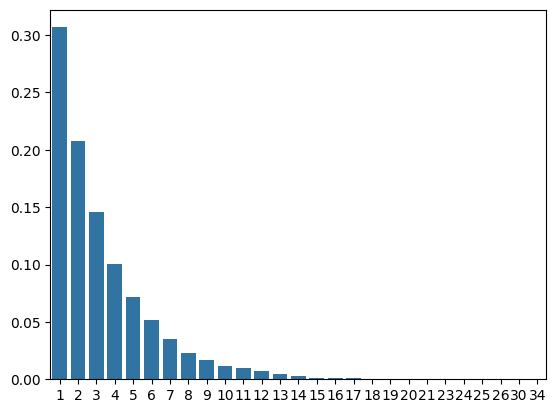

In [10]:
from typing import List
from mu_ppl import *
import matplotlib.pyplot as plt


def StoppingTime(d) -> int:
    time = 1
    while sample(d):
        time = time +1
    return time
    
with ImportanceSampling(num_particles=10000):
    ST: Categorical[float] = infer(StoppingTime, Bernoulli(0.7))  
    print(ST.stats())
    viz(ST)
    plt.show()


100%|██████████| 10000/10000 [00:00<00:00, 255843.85it/s]


(0.5057, 0.4999925091948145)


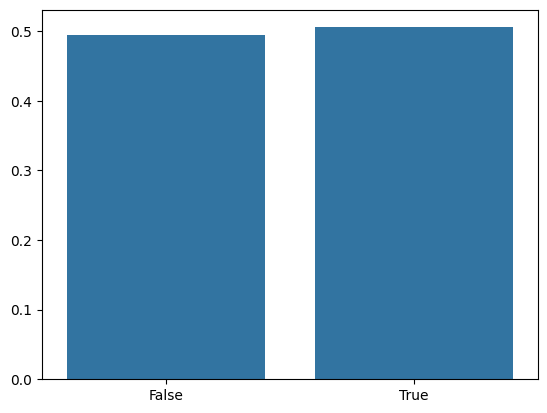

In [ ]:
from mu_ppl import *
import matplotlib.pyplot as plt

def FairCoin(d) -> bool:
    a = sample(d)
    b = sample(d)
    if (a and not b):
        return True
    elif (b and not a):
        return False
    else:
        return FairCoin(d)

with ImportanceSampling(num_particles=10000):
    FC: Categorical[bool] = infer(FairCoin, Bernoulli(0.3))
    print(FC.stats())
    viz(FC)
    plt.show()


Conditioning can be hard: `assume(d2<1)`

100%|██████████| 1000/1000 [00:00<00:00, 145262.31it/s]


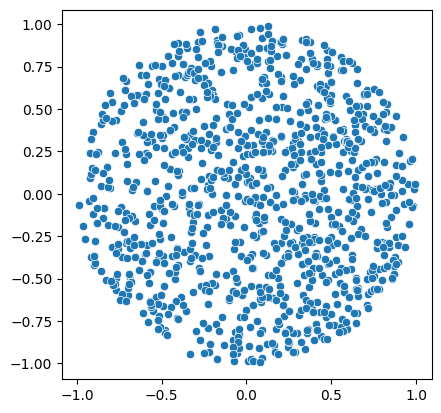

In [12]:
from typing import Tuple
from mu_ppl import *
import matplotlib.pyplot as plt
import seaborn as sns  # type: ignore

def HardDisk() -> Tuple[float, float]:
    x = sample(Uniform(-1, 1))
    y = sample(Uniform(-1, 1))
    d2 = x**2 + y**2
    assume(d2 < 1)
    return (x, y)
with RejectionSampling(num_samples=1000):
    dist: Empirical = infer(HardDisk) 
    x, y = zip(*dist.samples)
    sns.scatterplot(x=x, y=y)
    plt.axis("scaled")
    plt.show()

Conditioning can be soft: `observe(Gaussian(d2, 0.1), o)` condition the law given observations.

100%|██████████| 10000/10000 [00:00<00:00, 24359.23it/s]


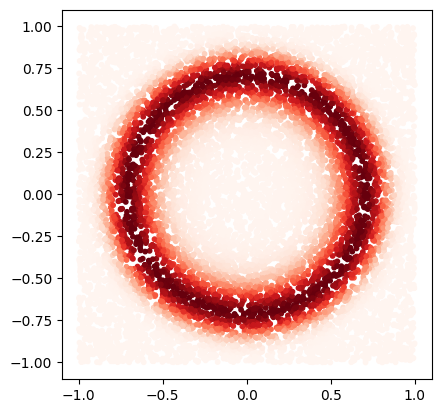

In [25]:
def SoftDisk() -> Tuple[float, float]:
    x = sample(Uniform(-1, 1))
    y = sample(Uniform(-1, 1))
    d2 = x**2 + y**2
    observe(Gaussian(d2, 0.1), 0.5)
    return(x, y)

with ImportanceSampling(num_particles=10000):
    dist: Categorical[Tuple[float, float]] = infer(SoftDisk)
    w = dist.probs
    x, y = list(zip(*dist.values))
    plt.scatter(x, y, c=w**0.5, cmap='Reds', s=10)
    plt.axis("scaled")
    plt.show()

## Some more examples

Copies of the result of sampling once a Bernoulli.

(4.0, 14.142135623730955)


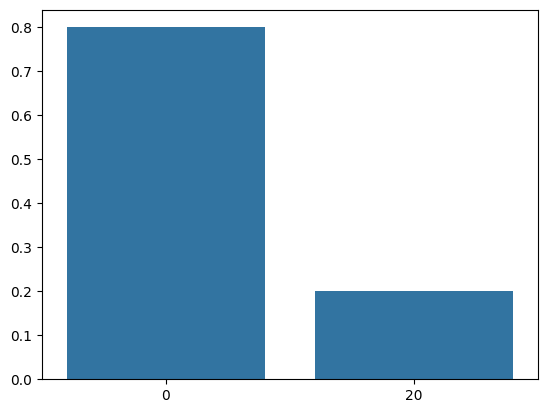

In [ ]:
from typing import List
from mu_ppl import *
import matplotlib.pyplot as plt


def FlipSum(n: int, d) -> int:
    x = sample(d, "bern")
    sum = 0
    for k in range(n):
        sum += x
    return sum

with Enumeration():
    dist: Categorical[float] = infer(FlipSum, 20, Bernoulli(0.2)) 
    print(dist.stats())
    viz(dist)
    plt.show()


Stream of i.i.d copies of a Bernoulli.

100%|██████████| 100000/100000 [00:01<00:00, 97360.95it/s]


(0.0035899999999999986, 2.2418490963429507)


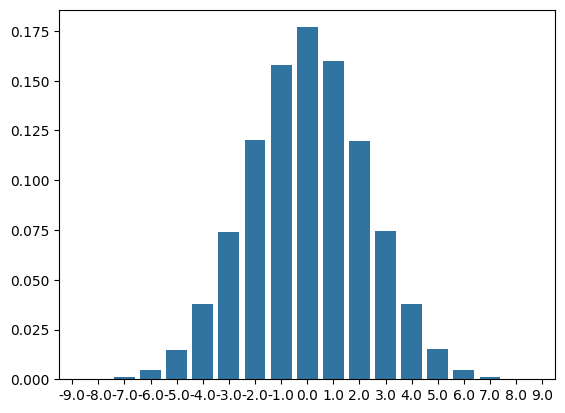

In [ ]:

def RandomWalk(n: int, d) -> int:
    s = 0
    for k in range(n):
        s += 0.5 - sample(d)
    return s 

with ImportanceSampling(num_particles=100000):
    ST: Categorical[float] = infer(RandomWalk, 20, Bernoulli(0.2))  
    print(ST.stats())
    viz(ST)
    plt.show()




Linear Regression

100%|██████████| 10000/10000 [00:01<00:00, 6083.00it/s]


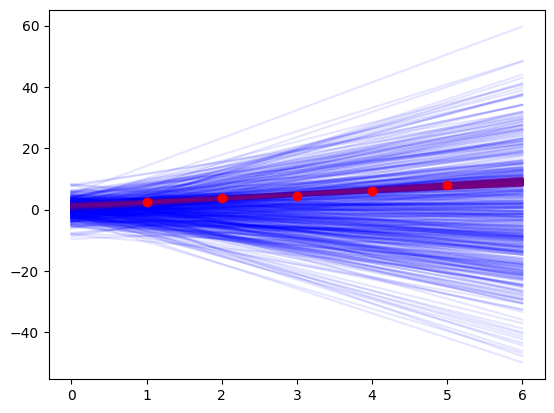

In [24]:
from typing import Tuple
from mu_ppl import *
import numpy as np
import matplotlib.pyplot as plt

def model0(data):
    m = sample(Gaussian(0.0, 3.0), name="a")
    b = sample(Gaussian(0.0, 3.0), name="b")
    f = lambda x: m*x +b
    return f

def model(data):
    m = sample(Gaussian(0.0, 3.0), name="a")
    b = sample(Gaussian(0.0, 3.0), name="b")
    f = lambda x: m*x +b
    for (x, y) in data:
        observe(Gaussian(f(x), 0.5), y)
    return f

data = [(1.0, 2.5), (2.0, 3.8), (3.0, 4.5), (4.0, 6.2), (5.0, 8.0)]

with ImportanceSampling(num_particles=10000):
    dist0: Categorical[Tuple[float,float]] = infer(model0, data)
    dist: Categorical[Tuple[float,float]] = infer(model, data)
    
    for i in range(500):
        x = np.linspace(0, 6, 2)
        f = dist.sample()
        f0 = dist0.sample()
        plt.plot(x, f0(x), color='blue', alpha=0.1, zorder=0)
        plt.plot(x, f(x), color='purple', alpha=0.1, zorder=0)
    

    x_obs = [obs[0] for obs in data]
    y_obs =  [obs[1] for obs in data]

    plt.scatter(x_obs, y_obs, color='red', zorder=1)
    plt.show()